# <font color="dodgerblue"> Finding an optimal model built to measure inflation </font>

<font color="olive">A few references that are mentioned in this writeup as resources for the information gathered here:

* [Investopedia and key influences of inflation](https://www.investopedia.com/ask/answers/111314/what-causes-inflation-and-does-anyone-gain-it.asp) shows this when talking about the free cash flow, and the amount of jobs available, the free money in the market, and the Gross Domestic Product are 3 key drivers.
* [Free Money in Market](https://fred.stlouisfed.org/series/M1SL) is a key metric in the amount of money in the market.
* The amount of job openings and turnover [JTSJOL](https://fred.stlouisfed.org/series/JTSJOL)
* Although not quite as clear, the BEA has [data on GDP](https://apps.bea.gov/iTable/?reqid=19&step=2&isuri=1&categories=survey#eyJhcHBpZCI6MTksInN0ZXBzIjpbMSwyLDNdLCJkYXRhIjpbWyJjYXRlZ29yaWVzIiwiU3VydmV5Il0sWyJOSVBBX1RhYmxlX0xpc3QiLCIzIl1dfQ==)
* Finally the Bureau of Labor and Statistics has data on CPI [CPI BLS](https://www.bls.gov/cpi/)
</font>

##1.  First, we want to import some of the key factors to all of the inflation. The data was massaged in a spreadsheet, saved as a CSV, and noting that GDP data came in quarterly, that data would have 3 month increments with the same numbers.


<font color="gold">**Note because Google Colab is cloud based, you need to run some of what is mentioned here in order to [upload .csv files to the cloud/colab](https://saturncloud.io/blog/uploading-local-files-using-google-colab/
):**</font>

Then, use the pandas.read_csv() command from there so they will be present in Colab.

<font color="gold">**It seems if you try to specfiy the datatype when reading in the files, they persist as objects so the type conversions needed to happen later. Another interesting issue was looping through the dataframes, and transpose them didn't seem to persist so they were transposed individually.**</font>

**After reading in the csv files:**

1) Transpose them so they are vertical, and create the following names:

|Data Column         | Title     |
|--------------------|-----------|
|Consumer Price Index| Trend_CPI |
|Free cash in economy| Trend_Cash|
|Gross Domestic Prod | Trend_GDP |
|Jobs to workers     | Trend_Work|

2) Make sure each datatype is of type float in the future case they need to work with our Tensors. *Also, it seems that float is the most versitile with all of the packages available for the model-building implemented here.*



In [1]:
import torch
import pandas as pd
import os
import numpy as np
from google.colab import files as fls
# Check iff the expected files exist currently in the cloud and provide an upload method with the files class to get data
if os.path.isfile("CPI_Categories_2013.csv") and os.path.isfile("GDP_Monthly_2013.csv") and os.path.isfile("JTSJOL_2013.csv") and os.path.isfile("M1_data_2013.csv"):
  print("All required files present")
else:
  fls.upload()


#Reading in the files as dataframes
CPI = pd.read_csv('/content/CPI_Categories_2013.csv',
                  header = None,
                  index_col = False)
Flowing_Cash = pd.read_csv('/content/M1_data_2013.csv',
                           header = None,
                           index_col = False)
Open_positions = pd.read_csv('/content/JTSJOL_2013.csv',
                             header = None,
                             index_col = False)
GDP = pd.read_csv('/content/GDP_Monthly_2013.csv',
                  header = None,
                  index_col = False)

#Get the dataframes in more of a vertical format for handling
Flowing_Cash = Flowing_Cash.T
Open_positions = Open_positions.T
GDP = GDP.T
CPI = CPI.T

#Provide the names of the columns of the dataframes to reflect accurate data
Flowing_Cash.columns =['Month','Trend_Cash']
Open_positions.columns =['Month','Trend_Work']
GDP.columns=['Month','Trend_GDP']
CPI.columns =['Month','Trend_CPI']

#Set data types
Flowing_Cash = Flowing_Cash.astype({'Month':'string','Trend_Cash':float})
Open_positions = Open_positions.astype({'Month':'string','Trend_Work':float})
GDP = GDP.astype({'Month':'string','Trend_GDP':float})
CPI = CPI.astype({'Month':'string','Trend_CPI':float})


Saving CPI_Categories_2013.csv to CPI_Categories_2013.csv
Saving GDP_Monthly_2013.csv to GDP_Monthly_2013.csv
Saving JTSJOL_2013.csv to JTSJOL_2013.csv
Saving M1_data_2013.csv to M1_data_2013.csv


##2. Merge data imports. Right now we can't merge <font color = "blue">because the columns don't match so **using the months for CPI**</font> will ensure they are all the same. *Further, let's create an incremented measure of the tick values, then the y-axis will get cluttered as well.*

* Use CPI labeling for all dataframe imports to ensure a consistent mergable column.
* Merge the independent files into a dataframe using that CPI labeling *(Eventually it will be necessary to convert those over to PyTorch tensors)*.

* Also create a vector of tick mark values for each y-axis and apend every 12th value/month to a list *(this started from May so that is the month you see here)*


In [5]:
#Ensure all data has the same row labels
Open_positions['Month']= CPI['Month']
Flowing_Cash['Month'] = CPI['Month']
GDP['Month']= CPI['Month']

#Set up your Inputs matrix (which has the GDP, Free cash, and Open Positions)
Inputs = pd.merge(Flowing_Cash, Open_positions,on=['Month','Month'])
Inputs = pd.merge(Inputs, GDP, on=['Month','Month'])

#Create vectors of tick marks by separating the 12 month spans by 10, using that as a step, and converting to a float.
CPI_Min, CPI_Max = [CPI['Trend_CPI'].min().astype(float),CPI['Trend_CPI'].max().astype(float)]
CPI_scale = np.arange(CPI_Min,CPI_Max,(CPI_Max-CPI_Min)/10,float)

FC_Min, FC_Max = [Flowing_Cash['Trend_Cash'].min().astype(float),Flowing_Cash['Trend_Cash'].max().astype(float)]
FC_scale = np.arange(FC_Min,FC_Max,(FC_Max-FC_Min)/10,float)

OP_Min, OP_Max = [Open_positions['Trend_Work'].min().astype(float),Open_positions['Trend_Work'].max().astype(float)]
OP_scale = np.arange(OP_Min,OP_Max,(OP_Max-OP_Min)/10,float)

GDP_Min, GDP_Max = [GDP['Trend_GDP'].min().astype(float),GDP['Trend_GDP'].max().astype(float)]
GDP_scale = np.arange(GDP_Min,GDP_Max,(GDP_Max-GDP_Min)/10,float)

Month_scale = []
for i, item in enumerate(CPI['Month']):
  if i % 12 == 0:
    Month_scale.append(item)



##3. Let's now take a look at our different datasets, and chart them out so we can better evaluate lag times and the pattern of our data.

* First, look at Matplotlib and use a shared axis (sharex=<font color="blue">True</font>) in order to see where the lags are between the inputs and CPI.
* Make sure we can see the month labels, with enough space between data.


<font color="gold">**Finally, note the CPI is sort of parabolic shaped indicating a 2nd degree polynomial might represent this data for this window. However, when considering the nature of inflation, we will want to represent it with an exponential equation ultimately.**</font>


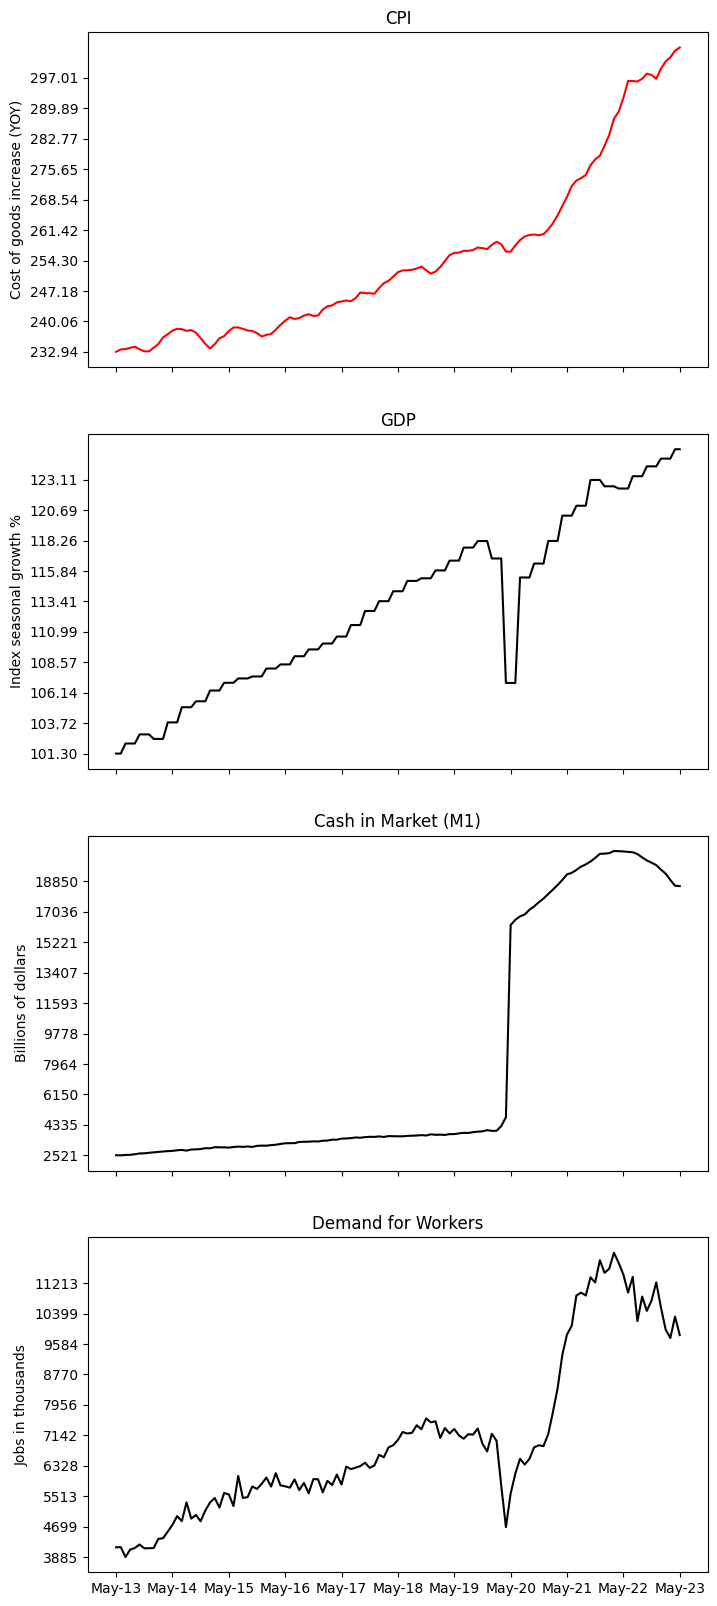

In [7]:
import matplotlib.pyplot as plt

#Plot out how this looks with enough space to see the differences
fig, axis = plt.subplots(4,1, sharex=True, figsize=(8,20))
axis[0].plot(CPI['Month'],CPI['Trend_CPI'],'r')
axis[0].set_title('CPI')
axis[0].set_yticks(CPI_scale)
axis[0].set_ylabel('Cost of goods increase (YOY)')
axis[0].set_xticks(CPI['Month'])
axis[1].plot(GDP['Month'],GDP['Trend_GDP'],'k')
axis[1].set_title('GDP')
axis[1].set_ylabel('Index seasonal growth %')
axis[1].set_yticks(GDP_scale)
axis[2].plot(Flowing_Cash['Month'],Flowing_Cash['Trend_Cash'],'k')
axis[2].set_title('Cash in Market (M1)')
axis[2].set_ylabel('Billions of dollars')
axis[2].set_yticks(FC_scale)
axis[3].plot(Open_positions['Month'],Open_positions['Trend_Work'],'k')
axis[3].set_title('Demand for Workers')
axis[3].set_yticks(OP_scale)
axis[3].set_ylabel('Jobs in thousands')
axis[3].set_xticks(Month_scale)

##4. Now that we have plotted the graphs, we need to <font color="blue">**use them to see what sort of "Lag" there is between variables.**</font>

* Define a range of time shifts from looking forward 18 months and month-by-month moving all input values forward until looking 5 months back. This will result in a dataframe for each.
* For each new dataframe, one for each input variable, iterate through from -5 to 18 and shift the entier dataset the amount of the iteration *-5, -4, .....17, 18*.
* Tack on the CPI numbers to each of the newly created dataframes (<font color="skyblue">**GDP_shift**</font>, <font color ="skyblue">**Flowing_Cash_shift**</font>, and <font color="skyblue">**Open_Positions_shift**</font>).
* **Now create a correlation matrix for each dataframe between each shift in time and the actual CPI numbers.** In other words, correlate the values of GDP when shifted 5 months forward with the CPI, then 4 months with CPI, all the way to 18 months back. Do that for all 3 newly created matricies.
* Map that out using the seaborn package to best see which shifts for each input variable have the greatest correlation. **We want to use the shifted values to account for the above mentioned lag.**



Index(['CPI', 'Flow_Cash', 'Open_Pos'], dtype='object')


<Axes: >

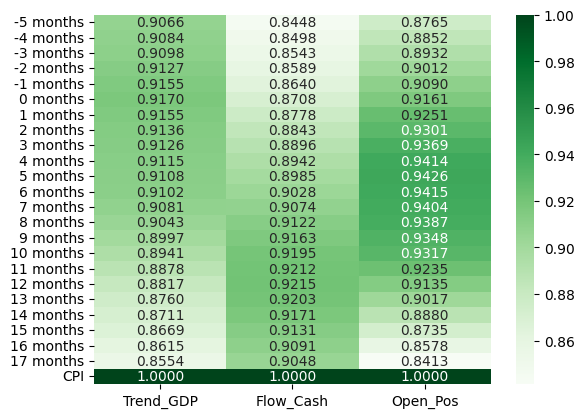

In [8]:
#Import Seaborn in advance for our new correlation
import seaborn as sbn

# Create new datasets based on shifting data forward -5 to 12 months (start with GDP, then Flowing_cash, then Open Positions)
lowshift = -5
highshift = 18
GDP_shift = pd.DataFrame(GDP['Trend_GDP']) #Create new dataframe from GDP (same done with the other inputs), and then fill
for i in range(lowshift,highshift):
  mnth = str(i) + " months"
  GDP_shift[mnth] = GDP['Trend_GDP'].shift(periods = i)

# Now Add the CPI data
GDP_shift['CPI'] = CPI['Trend_CPI']

#Flowing Cash
Flowing_Cash_shift = pd.DataFrame(Flowing_Cash['Trend_Cash'])
for i in range(lowshift,highshift):
  mnth = str(i) + " months"
  Flowing_Cash_shift[mnth] = Flowing_Cash_shift['Trend_Cash'].shift(periods = i)

Flowing_Cash_shift['CPI'] = CPI['Trend_CPI']

Open_positions_shift = pd.DataFrame(Open_positions['Trend_Work'])
for i2 in range(lowshift,highshift):
  mnth = str(i2) + " months"
  Open_positions_shift[mnth] = Open_positions_shift['Trend_Work'].shift(periods = i2)

Open_positions_shift['CPI'] = CPI['Trend_CPI']

#Set up the rounding decimal just so we can distinguish the maximum correlations and create correlation matrices
r = 4 #Four decimal places allow us to see the distinction between closely valued shifts.

GDP_corr = GDP_shift.corr().round(r)
Flowing_Cash_corr = Flowing_Cash_shift.corr().round(r)
Open_positions_shift_corr = Open_positions_shift.corr().round(r)

#Create one more dataframe getting the correlations just created
OvrAll_corr = pd.DataFrame(GDP_corr['CPI'])
OvrAll_corr['Flow_Cash'] = Flowing_Cash_corr['CPI']
OvrAll_corr['Open_Pos']=Open_positions_shift_corr['CPI']

print(OvrAll_corr.columns)
#Rename the columns for the CPI due to the fact that it was labeled like that when creating the dataframe.
#Drop the first row as it has headers
OvrAll_corr.rename(columns ={'CPI':'Trend_GDP'}, inplace =True)
OvrAll_corr = OvrAll_corr.iloc[1:]
# OvrAll_corr

# Finally, show the seaboarn color chart of the correlations.
sbn.heatmap(OvrAll_corr,annot=True, cmap = 'Greens', fmt = '.4f')


### 4.2 We can see the maximum correlations occur at 0 month shifts (for <font color="skyblue">GDP</font>), 12 month shifts (for <font color="skyblue">cash flow</font>), and 5 months (for <font color="skyblue">open positions</font>). We will build the regression model using these time shifts for both cash flow and open positions.

<font color = "gold" size = "5">**However, a problem is the new values inserted NANs due to the lack of earlier data from the import so we need to replace those. Regression techniques will help here.**</font>


* Use regression analysis to create "high probability" data points accounting for the earlier 12 month, and 5 month shifts of free money cashflow and available workers. <font color ="gold">*Using graphs above, it is determined the most "constant" regression patterns were **39 months** less than the full time for Trend_Cash and **49 months** for Trend_Work.*</font>
* <font color="blue">Using numpy\'s polyfit, create the appropriate regression lines and extract the data points from those</font> **5 months back** and **12 months back** for open positions and free cash respectively.
* Looking at the graphs above use a linear equation for the cash flow up to March 2020, and a **3rd degree polynomial** for the open positions April 2019.
  *Graph these out for validation and <font color ="grey">**create "cut-off" lines where the added regression points in grey stop.**</font>*
* Add those inputs to the Inputs dataframe for the <font color="skyblue">**Trend_Cash**</font> and <font color="skyblue">**Trend_Work**</font>.

You can see these points plotted in the graphs below for each, and there are some grey color lines showing where the "inferred" points end and actual data comes in.


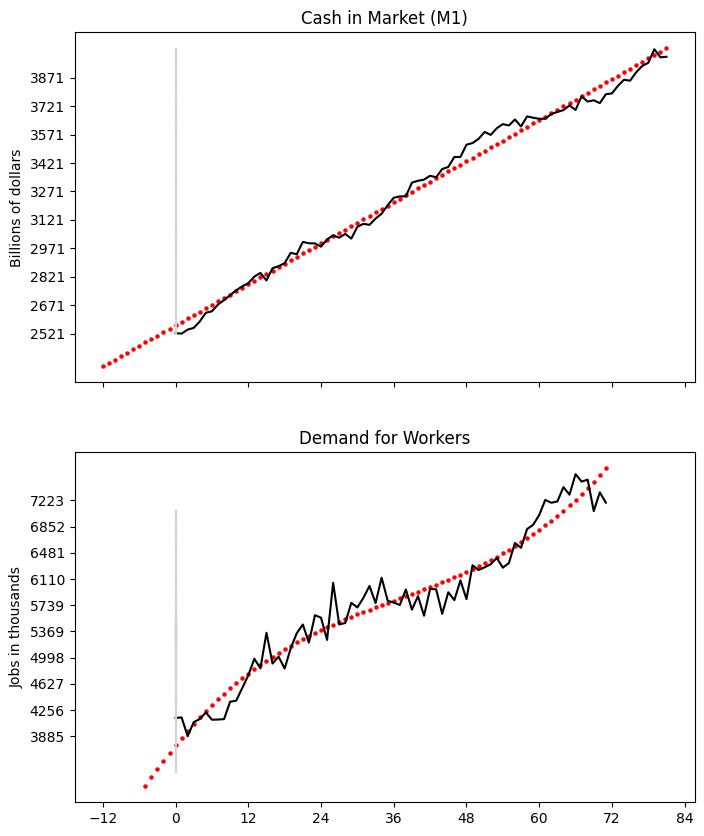

In [9]:
%matplotlib inline
#Create new pandas series for the cash and work cutting off the irregular patterns
Cash_cut= Inputs['Trend_Cash'][0:(len(Inputs['Trend_Cash'])-39)]
Cash_month = np.arange(0,len(Cash_cut))
Work_cut= Inputs['Trend_Work'][0:(len(Inputs['Trend_Work'])-49)]
Work_month = np.arange(0,len(Work_cut))
#Reset the Free cash scaling and Open position scaling
FC_scale = np.arange(Cash_cut.min(),Cash_cut.max(),(Cash_cut.max()-Cash_cut.min())/10,float)
OP_scale = np.arange(Work_cut.min(),Work_cut.max(),(Work_cut.max()-Work_cut.min())/10,float)

#Now, create new polynomials based on these
cash_poly = np.polyfit(Cash_month,Cash_cut, deg =1)
cash_fn = np.poly1d(cash_poly)
work_poly = np.polyfit(Work_month,Work_cut, deg =3)
work_fn = np.poly1d(work_poly)


#Create a new series moving 12 months back for open positions and 5 for free cash; also create mins/maxes for y and x limits
x_cash = np.arange(-12, len(Cash_cut))
y_cash = cash_fn(x_cash) #Note the first 12 records here are going to be replacing NAN values
x_work = np.arange(-5, len(Work_cut))
y_work = work_fn(x_work) #Note the first 5 records here are going to be replacing NAN values
cash_min_x, cash_max_x, cash_min_y, cash_max_y = x_cash.min(), x_cash.max, y_cash.min(), y_cash.max()
work_min_x, work_max_x, work_min_y, work_max_y = x_work.min(), x_work.max, y_work.min(), y_work.max()

#Create a new month scale for adjusted values
new_mon_sc = []
for i in range(-12,len(x_cash)):
  if i % 12 ==0:
    new_mon_sc.append(i)

#Graph this to see how new points match up
fig, axis = plt.subplots(2,1, sharex=True, figsize=(8,10))
axis[0].set_title('Cash in Market (M1)')
axis[0].plot(np.arange(0,len(Cash_month)),Cash_cut,'k')
axis[0].scatter(x_cash, y_cash,c='r',s=5)
axis[0].set_yticks(FC_scale)
axis[0].set_ylabel('Billions of dollars')
axis[0].plot(np.zeros(len(Cash_cut)),Cash_cut,'lightgrey')
axis[1].set_title('Demand for Workers')
axis[1].plot(np.arange(0,len(Work_month)),Work_cut,'k')
axis[1].scatter(x_work,y_work,c='r', s=5)
axis[1].plot(np.zeros(len(Work_cut)),Work_cut-500,'lightgrey')
axis[1].set_yticks(OP_scale)
axis[1].set_ylabel('Jobs in thousands')
axis[1].set_xticks(new_mon_sc)

###4.3 Now insert the new shifted <font color="skyblue">**y_cash**</font> and <font color="skyblue">**y_work**</font> values into the Inputs dataframe and handle NAN values:
* First, just set "Trend_Cash" and "Trend_Work" columns *(note the GDP didn't need a shift)*.
* Then insert that into our overall Inputs[] dataframe.



In [11]:
# from torchvision import transforms
# Now replace all of the NAN values with newly created regression values
Flowing_Cash_shift['12 months'][0:12] = y_cash[0:12]
Open_positions_shift['5 months'][0:5]= y_work[0:5]

#Replace the original data for cash and work with the newly shifted values
Inputs['Trend_Cash'] = Flowing_Cash_shift['12 months']
Inputs['Trend_Work'] = Open_positions_shift['5 months']


##5. Now it is helpful for the possibility of deep learning <font color="blue">**to make every column numeric and convert into a PyTorch tensor which will also require numerical formatting for our analysis.**</font>

* Create indexing via lambda expressions based on the month.
* Convert to a PyTorch tensor for now  (<font color="skyblue">**Inputs_tens**</font>).
* Provide a test check to ensure CPI and Inputs tensors are of the same length.


**<font color="gold">Note the prime reason is to get the data in numerical format is for our machine learning which is a good standard practise. There are other ways to get that accomplished, but for the purposes of creating the potential for neural network development this was chosen.**</font> *There could be alternative methods here.*

In [12]:
inp_lab =[]
out_lab =[]

if not Inputs['Month'][0] ==0:
  for i in range(len(Inputs['Month'])):
    inp_lab.append(i)

  for j in range(len(CPI['Month'])):
    out_lab.append(j)

  #Replace the index of Inputs with the month names.
  Inputs = Inputs.rename(index=lambda x:Inputs['Month'][x])

  #Replace the index of the CPI with the month names.
  CPI = CPI.rename(index =lambda x:CPI['Month'][x])

  #Now change the labeling of the months to a numeric
  Inputs['Month']=inp_lab
  CPI['Month'] = out_lab

#Convert to tensor
Inputs_tens = torch.tensor(Inputs.values, dtype=torch.float32)

#Make sure that CPI has same length as Inputs as the data for CPI seems to be more recent
CPI = CPI[:len(Inputs_tens)]

#Check to make sure they have the same length
if not len(CPI) == len(Inputs_tens):
  print(f"Here are the inputs:\n {Inputs_tens.shape} \n Here are outputs: \n{CPI.shape} something is off.")
else:
  print(f"Inputs tensor shape: {Inputs_tens.shape} \n Inputs dataframe:{Inputs}")

Inputs tensor shape: torch.Size([121, 4]) 
 Inputs dataframe:        Month    Trend_Cash    Trend_Work  Trend_GDP
May-13      0   2348.319718   3175.203891    101.295
Jun-13      1   2366.367519   3301.027854    101.295
Jul-13      2   2384.415320   3422.303969    102.097
Aug-13      3   2402.463121   3539.144649    102.097
Sep-13      4   2420.510922   3651.662307    102.097
...       ...           ...           ...        ...
Jan-23    116  20506.100000  10198.000000    124.786
Feb-23    117  20533.500000  10854.000000    124.786
Mar-23    118  20664.200000  10471.000000    124.786
Apr-23    119  20650.800000  10746.000000    125.533
May-23    120  20638.800000  11234.000000    125.533

[121 rows x 4 columns]


##5.2 <font color="blue">**Need to shuffle the values**</font> so that when we perform a test and train split <font color="blue">**we don't have disproportionate values representing high inflationary periods**. <font size="3">*After 2020 the data is clearly different than before.*</font>

* Create a **<font color="skyblue">Full_Tensor</font>** so that the ordination of the inputs and outputs stay together when shuffling. We can just use the `torch.randperm()` function. *Note the cell below shows a validation that this does what is expected.*
* Before doing that, make sure to have the same dimensionality and then horizontally stack these inputs together into one Tensor.
*<font color="blue">**After that, create a test and training split of the data considering it has been shuffled.**</font>
  * <font color="gold" size="4">To get the right split size, we are getting just over **80% (81.8 to be more precise)**. and considering <font color="skyblue">**Full_Tensor**</font> is of length **11^2 (121) splitting into batches of size 11 and taking 2 of those for testing** is appropriate.</font>
  * The first cell tests to be sure `randperm()` does what we want and that is confirmed. In the second cell we display all of the other processing described here.



In [13]:
#Proof that randperm will shuffle your tensor
tch = [3,4,7,2,5]
tch = torch.tensor(tch)
# Print out a randomized version of the original
tch[torch.randperm(len(tch))]

tensor([5, 4, 7, 2, 3])

###5.3 <font color="blue">**Now create a test and training split of the data considering it has been shuffled.**</font>
 Create a split of training and testing data also considering that <font color = "skyblue">Inputs_Tens</font> is a 2-d matrix. Then set up dataloaders for our models.

* <font color="gold" size="4">To get the right split size, we are getting just over 80% (81.8 to be more precise). and considering <font color="skyblue">**Full_Tensor**</font> is of length 11^2 (121) splitting into batches of size 11 and taking 2 of those for testing is appropriate.
* There is more commented out code in the case that we wanted to use more of a PyTorch-based neural network with more data.</font>



In [14]:
from torchvision import transforms

#First get this into one tensor
if len(CPI) == len(Inputs_tens):
  yvals = torch.tensor(CPI['Trend_CPI']).unsqueeze(dim=1)
  Full_Tensor = torch.hstack((Inputs_tens,yvals)) #Place all inputs and outputs in one tensor (note the need for double brackets here)
  print(Inputs_tens.shape)

#Check to make sure we have the right sized tensors after combining
print(Full_Tensor.shape)

#Here is how we can shuffle the rows using randperm (note we need to shuffle the Full_Tensor to keep inputs and outputs together.)
Full_Tensorc=Full_Tensor[torch.randperm(len(Full_Tensor))]

i, j = 1 ,121

#Here is how we can shuffle the rows using randperm
Full_Tensor=Full_Tensor[torch.randperm(len(Full_Tensor))]

#Split the data (considering the number is divisible by 11 use a variable to split test data by 2 sets of 11) and make an array
#We could use train_test_split from the sklearn library, but this just gives more visibility to numeric splitting logic.
splitter = (j-22*i)/j
train_split = int(splitter*len(Full_Tensor))
X_train, y_train = Full_Tensor[:train_split,0:4].numpy(), Full_Tensor[:train_split, 4:5].numpy()
X_test, y_test = Full_Tensor[train_split:,0:4].numpy(), Full_Tensor[train_split:, 4:5].numpy()
train_data, test_data = Full_Tensor[:train_split,:].numpy(), Full_Tensor[train_split:,:].numpy()

X_train.shape, X_test.shape #ensure the right shapes that rows = 121, and columns are both 4.

torch.Size([121, 4])
torch.Size([121, 5])


((99, 4), (22, 4))

##6. Now that we have shifted the data, and the data is numeric in nature, let's <font color="blue">**set up a few models to evaluate different combinations.**</font>

<font color="gold" size="4">

**As noted above, the CPI curve seems to be of a <u>2nd degree polynomial</u>, so the model should reflect it's relation to time.** *Ultimately, this is just to see which models fit the best. We will use an exponential function for our final fitting, but this shows which matched best.</font>

Let's compare and obtain:

* A regression model on each individual input with the CPI

* A regression model on all 3 inputs against the CPI

* The mean squared error and absolute error for each to compare all

* We will use the Sklearn PolynomialFeatures method for the polynomial regression to fit all of this.

*All of this done with the newly shifted values and see which performs best. You can see the results in the dataframe at the bottom.*

In [15]:
#Import the right packages
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#Reset the data to frames
X= X_train

#Set the 2 degree polynomial and get the predicted regression values for each individual set
p2_deg = PolynomialFeatures(degree = 2, include_bias=False)
pred_Cash = p2_deg.fit_transform(X[:,1].reshape(-1,1))
pred_Work = p2_deg.fit_transform(X[:,2].reshape(-1,1))
pred_GDP = p2_deg.fit_transform(X[:,3].reshape(-1,1))


#Set up the fitting and predictions with the CPI. Next get the predictions for all 4 mixes
LinReg = LinearRegression()
Cash_LinReg = LinReg.fit(pred_Cash,y_train)
Work_LinReg = LinReg.fit(pred_Work,y_train)
GDP_LinReg = LinReg.fit(pred_GDP,y_train)

#Predictions on all 4 mixes
Cash_Pred = LinReg.predict(pred_Cash)
Work_Pred = LinReg.predict(pred_Work)
GDP_Pred = LinReg.predict(pred_GDP)


# #Finally try the 2 degree polynomial on all variants and then get a prediction for all
if X.ndim != 2:
  pred_All = p2_deg.fit_transform(X.reshape[-1,1])
else:
  pred_All = p2_deg.fit_transform(X)
All_LinReg = LinReg.fit(pred_All, y_train)
All_Pred = LinReg.predict(pred_All)

#Finally, let's evaluate the performance of each
Cash_Err_sq, Cash_Err = mean_squared_error(y_train, Cash_Pred), mean_absolute_error(y_train, Cash_Pred)
Work_Err_sq, Work_Err = mean_squared_error(y_train, Work_Pred), mean_absolute_error(y_train, Work_Pred)
GDP_Err_sq, GDP_Err = mean_squared_error(y_train, GDP_Pred), mean_absolute_error(y_train, GDP_Pred)
All_Err_sq, All_Err = mean_squared_error(y_train, All_Pred), mean_absolute_error(y_train, All_Pred)

Errors = pd.DataFrame([[Cash_Err, Cash_Err_sq],[Work_Err,Work_Err_sq],[GDP_Err,GDP_Err_sq],[All_Err,All_Err_sq]])
# print(f"Cash error: {Cash_Err:.3f}, Work error: {Work_Err:.3f}, GPP Error: {GDP_Err:.3f}, All {All_Err}")
# print(f"Cash sq error: {Cash_Err_sq:.3f}, Work sq error: {Work_Err_sq:.3f}, GPP sq Error: {GDP_Err_sq:.3f}, All sq {All_Err_sq}")
Errors.columns = ['Absolute Error','Mean Squared Error']
Errors.rename(index = {0: 'Cash',1: 'Work',2: 'GDP',3: 'All'}, inplace=True)
print("Here are the error values for each showing the combination of factors has the lowest error rate: \n")
Errors

Here are the error values for each showing the combination of factors has the lowest error rate: 



,Absolute Error,Mean Squared Error
Cash,1.174845e+07,5.670620e+14
Work,7.254392e+06,7.896293e+13
GDP,3.238945e+00,2.215152e+01
All,8.897137e-01,1.299216e+00


###6.2 <font color="blue">**Using the information above, build our model around the combined values.**</font>
<font color="gold" size="4">We see that while GDP is the strongest indicator, all inputs using a multi-linear regression predict best results, we will use all 3 variants.</font>

So, above we used a 2nd degree polynomial for the CPI, <u>however, if you look at inflation overall, it is exponential in nature, not parabolic.</u> The process [implemented here](https://data36.com/polynomial-regression-python-scikit-learn/) was useful above, and there are pieces of that process we can use. For this process of fitting to an exponential curve:

* We need to first linearize the curved/exponential data using the inverse. Here it is seen with the
  *A function that will allow us to extract the best fit values of the exponential function data is the [numpy.polifit() function](https://cppsecrets.com/users/25161031129711997110104971141051151045564103109971051084699111109/How-to-do-logarithmic-curve-fitting-in-Python.php). *However, since we will have a model that will carry these values, that isn't as relevant here.*
* Then, we can perform the multi-linear regression against the newly linearized data. <font color="skyblue">**y_ln**</font> and <font color="skyblue">**y_tr_ln**</font>.
  * *Note the trick here (if you aren't familiar) converting the data to be lineaar for regression, and then inverting that functionality again to make the results of the regression exponential.*
* Now, as suggested just above, we use the `np.exp()` function to make the curve exponential again and fit close to the original data.

<font color="blue">Now we want to see the test vs training results of this regression</font>:

* Sort the shuffled data so it in order again for graphing purposes.
* Set the Mean Absolute Percent Error for test of training into a dataframe to see. <font color="skyblue">**Mape**</font>
* Plot them next to each other to see if the predictions show any "red flags".




,Train,Test
0,Training Percentage Error,Testing Percentage Error
1,0.009088,0.012718


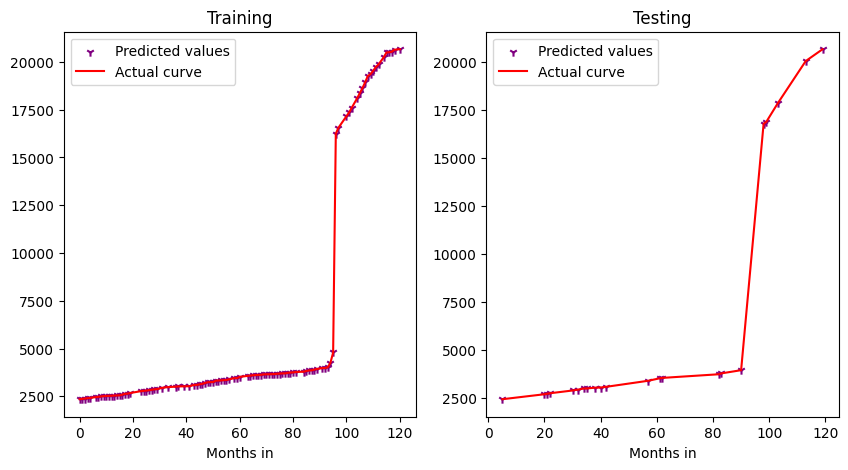

In [16]:
import sklearn.metrics as mtr
from numpy.ma.extras import hstack


#First, we run an exponential function between CPI and just flat time numbers
A, B, a, b   = np.arange(0,len(y_train), 1), y_train, np.arange(0,len(y_test),1), y_test
# exForm = np.polyfit(A, np.log(B),1)

#Ok, so we would need to run linear regression against the linearized data from the CPI.
#Then, you would get predications bassed on that relationship to X_train (not A). Look at LinearRegression on tablet if this doesn't work.
Model_LinReg = LinearRegression()
Model_LinReg.fit(X_train, np.log(B))
y_ln, y_tr_ln = Model_LinReg.predict(X_test), Model_LinReg.predict(X_train)

#Now use the numpy exponential formula to pop this back out (you don't need the exForm created above likely, but it is possible):
y_pred, y_train_pred = np.exp(y_ln), np.exp(y_tr_ln)

#Here we need to now pair up the y_pred and X_test values as well as the y_test values and sort by X_test. Same with Train
#It helps to sort this back to the original order after shuffling. Then plot the results
Actual , Actual_tr = np.hstack((X_test, y_test)), np.hstack((X_train, y_train))
Actual.sort(0)
Actual_tr.sort(0)
Predicted, Predicted_tr = np.hstack((X_test, y_pred)), np.hstack((X_train, y_train_pred))
Predicted.sort(0)
Predicted_tr.sort(0)

#Get the percentage
Mape = pd.DataFrame({'Train':['Training Percentage Error', mtr.mean_absolute_percentage_error(y_train, y_train_pred)],
                     'Test':['Testing Percentage Error',mtr.mean_absolute_percentage_error(y_test, y_pred)]})

fig, axis = plt.subplots(1,2,figsize = (10, 5))
axis[0].scatter(Predicted_tr[:,0], Predicted_tr[:,1],color = "purple", marker = "1")
axis[0].plot(Actual_tr[:,0], Actual_tr[:,1],color = "red")
axis[0].set_title('Training')
axis[0].set_xlabel("Months in")
axis[0].legend(labels=('Predicted values', 'Actual curve'),loc=2)
axis[1].scatter(Predicted[:,0], Predicted[:,1],color = "purple", marker = "1")
axis[1].plot(Actual[:,0], Actual[:,1],color = "red")
axis[1].set_title('Testing')
axis[1].set_xlabel("Months in")
axis[1].legend(labels=('Predicted values', 'Actual curve'),loc=2)

Mape

##7. <font color="blue">**Let's return to our original predictions, and see if we can't use this data on more recent inputs.**</font>

* Get data from full tensor before splitting into training and testing sets.
* Take the data from earlier tick marks and graph full set against CPI.
* Export the Model_LinReg to disk, and define a function to call that back in for other data.


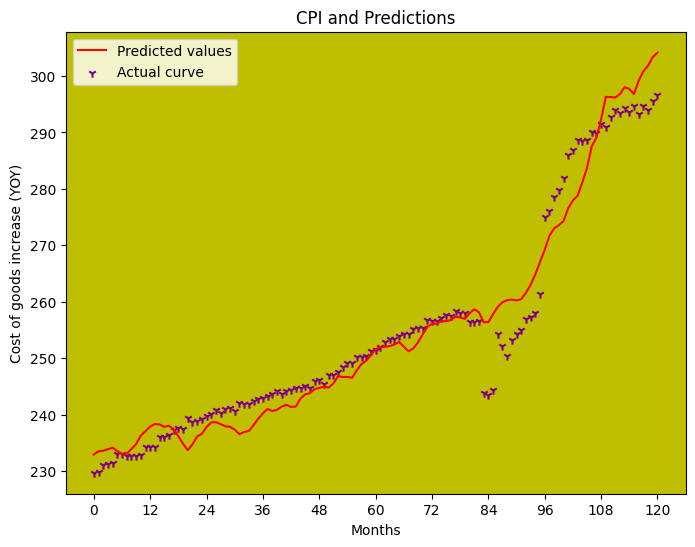

In [17]:
#Weigh the inputs tensors against the values for CPI
%matplotlib inline
Ins = Inputs_tens[:,1:4].numpy()
Outs = yvals.numpy()
Model_LinReg = LinearRegression()
Model_LinReg.fit(Ins, np.log(Outs))
Outs_ln = Model_LinReg.predict(Ins)
Outs_pred = np.exp(Outs_ln)

ticks = []
#Reset scale
for i, item in enumerate(CPI['Month']):
  if i % 12 == 0:
    # yr = 13 + int(item)
    # mnth = "May " + str(yr)
    ticks.append(item)


#Plot initial graph
fig= plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(CPI['Month'], CPI['Trend_CPI'], 'r')
ax.scatter(CPI['Month'], Outs_pred, marker="1", color="purple")
ax.set_facecolor("y")
ax.set_title("CPI and Predictions")
ax.set_ylabel("Cost of goods increase (YOY)")
ax.set_xlabel("Months")
ax.legend(labels=('Predicted values', 'Actual curve'),loc=2)
ax.set_xticks(ticks)


###7.1 <font color="blue">Now you can save the model to an address so you can use it later.</font>

In [13]:
import joblib
Address = input("Please enter a place to save the model")
joblib.dump(Model_LinReg, Address)

Please enter a place to save the modelNA


['NA']

##8. Ok, now let's finally <font color="blue">**define a function to export the model**</font> and then use it with new data.
We need to:
* Define a function that performs the linear transformation needed (if working with more than one data point)
* Load the model somewhere on disk
* Upload the model and the data.
* Finally show the results either in tabular form or graphically for larger datasets.

<font color="gold" size="4"> Note because the data for the time being is expected to be exponential in nature, for the <font color="black"><u>near future</u></font> we know the model has been trained on <font color="black"><u>linearized exponential data</u></font> we can just predict on incoming data that has the 3 requisite inputs, and we just need to exponentialize the predictions.</font>

In [19]:
#First upload your files
fls.upload()

#Set up a function so that you can ensure the right data structure for the model.
def inf_predict(data):
  df = pd.read_csv("/content/"+data+".csv")

  #Sometimes the data comes in with an index or left column label. This massages that out
  if len(df.columns)==4:
    df = df.iloc[:,1:4]
    df.to_csv("/content/"+data_name+".csv",index=False)
  elif len(df.columns)!=3:
    print(f"Need to have 3 input columns for the named dataset. You have {len(df.columns)}")
  else:
    y_ln = Model_LinReg.predict(df)
    y_pred = np.exp(y_ln)
    df['Predicted values']=y_pred
    return df

data_name = input("What is the name of your data input? Make sure it has 3 columns of data for all 3 inputs.")

y= pd.DataFrame(inf_predict(data_name))
print(f"Here is the original dataset with predicted values: \n {y}")


Saving Trial_data.csv to Trial_data.csv
What is the name of your data input? Make sure it has 3 columns of data for all 3 inputs.Trial_data
Here is the original dataset with predicted values: 
         M1  JTSTOL      GDP  Predicted values
0  18569.8    9616  113.325        273.753858
1  18506.9    9165  113.325        272.835669
2  18447.0    8920  113.325        272.306877
3  18320.4    9610  113.325        273.437953


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
